<a href="https://colab.research.google.com/github/ShrutiD-05/EWasteGenerationClassification/blob/main/Week3_final_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [ ]:
!cp -r drive/MyDrive/train /content/
!cp -r drive/MyDrive/val /content/
!cp -r drive/MyDrive/test /content/

trainpath = '/content/train'
validpath = '/content/val'
testpath  = '/content/test'


In [ ]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (260,260), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
datatrain = tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (260,260), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (260,260), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = preprocess_input(image)
    return image, label

datatrain = datatrain.map(preprocess, num_parallel_calls=AUTOTUNE)
datavalid = datavalid.map(preprocess, num_parallel_calls=AUTOTUNE)
datatest = datatest.map(preprocess, num_parallel_calls=AUTOTUNE)

datatrain = datatrain.prefetch(buffer_size=AUTOTUNE)
datavalid = datavalid.prefetch(buffer_size=AUTOTUNE)
datatest = datatest.prefetch(buffer_size=AUTOTUNE)


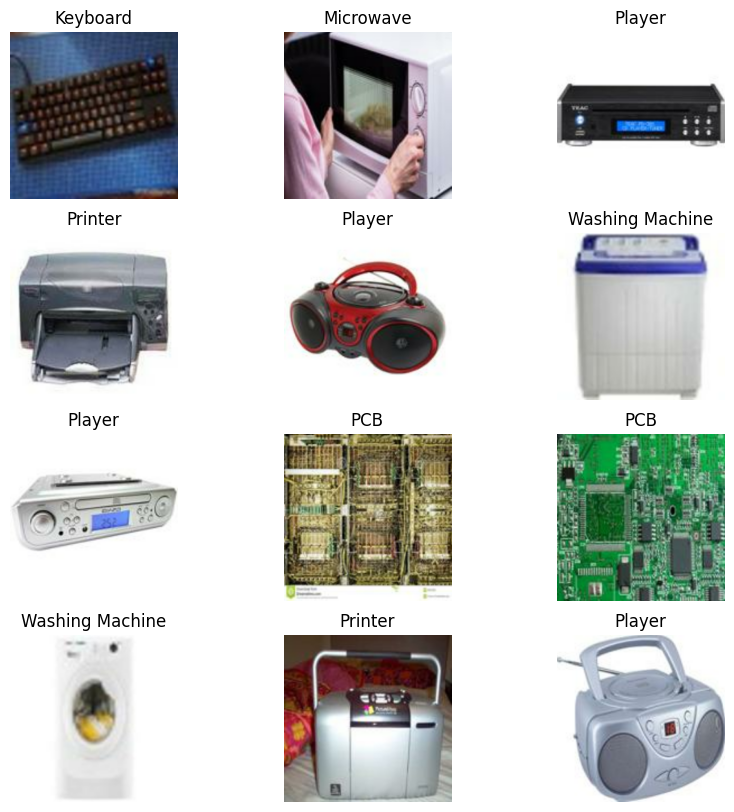

In [ ]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


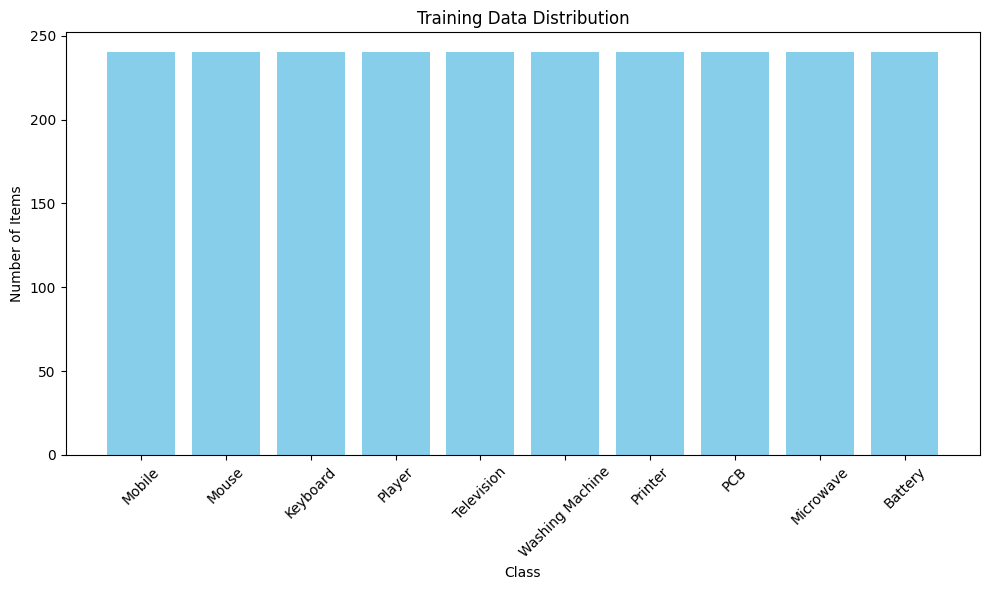

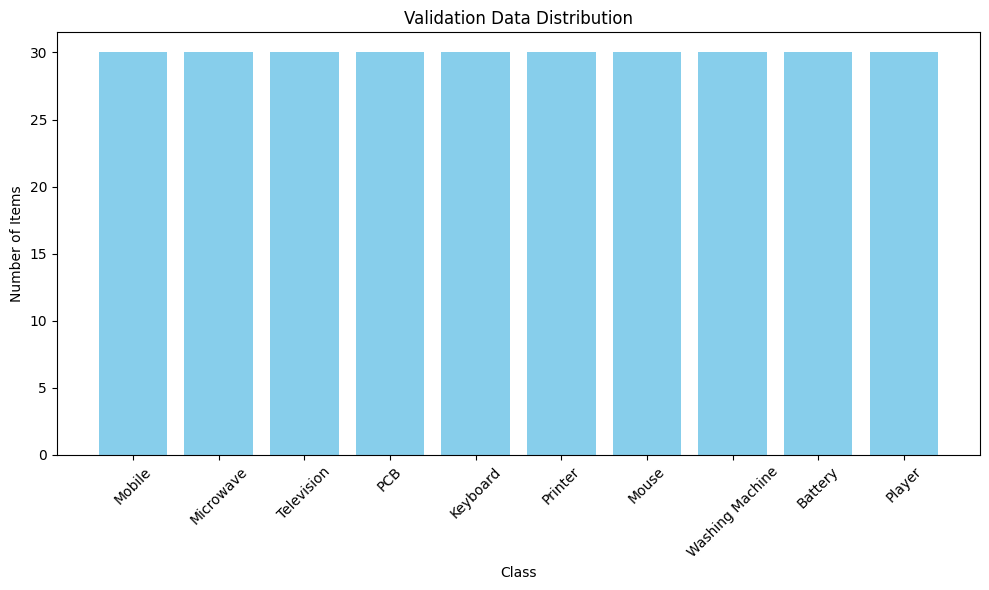

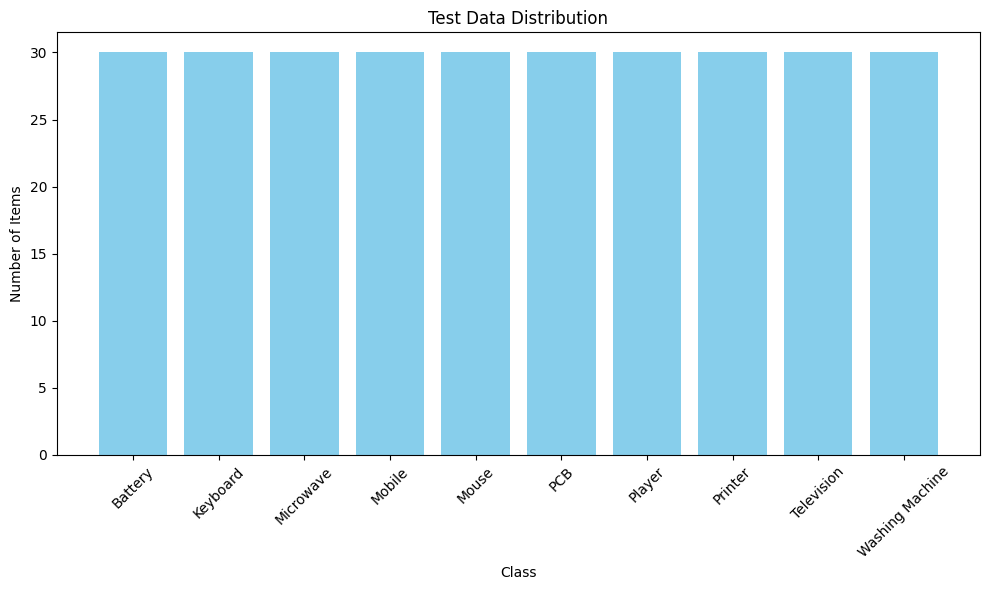

In [ ]:
def plot_class_distribution(dataset, class_names, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1


    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class


    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


plot_class_distribution(datatrain, class_names, "Training Data Distribution")
plot_class_distribution(datavalid, class_names, "Validation Data Distribution")
plot_class_distribution(datatest, class_names, "Test Data Distribution")

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B2(
    input_shape=(260, 260, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(260, 260, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['Accuracy'])

In [ ]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=6,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5", monitor="val_loss", save_best_only=True, verbose=1
)

In [ ]:
# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=15,                      # Number of training epochs
    callbacks=[early, checkpoint]               # List of callbacks to apply during training (e.g., early stopping)
)


Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - Accuracy: 0.2003 - loss: 2.1965
Epoch 1: val_loss improved from inf to 1.37343, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 417ms/step - Accuracy: 0.2018 - loss: 2.1935 - val_Accuracy: 0.8400 - val_loss: 1.3734
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - Accuracy: 0.7285 - loss: 1.3376
Epoch 2: val_loss improved from 1.37343 to 0.74074, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - Accuracy: 0.7296 - loss: 1.3355 - val_Accuracy: 0.9700 - val_loss: 0.7407
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - Accuracy: 0.9518 - loss: 0.8029
Epoch 3: val_loss improved from 0.74074 to 0.42065, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 370ms/step - Accuracy: 0.9519 - loss: 0.8016 - val_Accuracy: 0.9700 - val_loss: 0.4206
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - Accuracy: 0.9769 - loss: 0.5042
Epoch 4: val_loss improved from 0.42065 to 0.26773, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - Accuracy: 0.9770 - loss: 0.5034 - val_Accuracy: 0.9800 - val_loss: 0.2677
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - Accuracy: 0.9865 - loss: 0.3356
Epoch 5: val_loss improved from 0.26773 to 0.19202, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - Accuracy: 0.9865 - loss: 0.3353 - val_Accuracy: 0.9767 - val_loss: 0.1920
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - Accuracy: 0.9921 - loss: 0.2409
Epoch 6: val_loss improved from 0.19202 to 0.15491, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - Accuracy: 0.9921 - loss: 0.2409 - val_Accuracy: 0.9767 - val_loss: 0.1549
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - Accuracy: 0.9869 - loss: 0.1958
Epoch 7: val_loss improved from 0.15491 to 0.13316, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 364ms/step - Accuracy: 0.9869 - loss: 0.1956 - val_Accuracy: 0.9767 - val_loss: 0.1332
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - Accuracy: 0.9933 - loss: 0.1485
Epoch 8: val_loss improved from 0.13316 to 0.11262, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 373ms/step - Accuracy: 0.9933 - loss: 0.1485 - val_Accuracy: 0.9800 - val_loss: 0.1126
Epoch 9/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - Accuracy: 0.9899 - loss: 0.1336
Epoch 9: val_loss improved from 0.11262 to 0.10683, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 367ms/step - Accuracy: 0.9899 - loss: 0.1335 - val_Accuracy: 0.9767 - val_loss: 0.1068
Epoch 10/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - Accuracy: 0.9910 - loss: 0.1206
Epoch 10: val_loss improved from 0.10683 to 0.09684, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 373ms/step - Accuracy: 0.9910 - loss: 0.1206 - val_Accuracy: 0.9767 - val_loss: 0.0968
Epoch 11/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - Accuracy: 0.9919 - loss: 0.0932
Epoch 11: val_loss improved from 0.09684 to 0.09227, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - Accuracy: 0.9919 - loss: 0.0932 - val_Accuracy: 0.9767 - val_loss: 0.0923
Epoch 12/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - Accuracy: 0.9942 - loss: 0.0888
Epoch 12: val_loss did not improve from 0.09227
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 351ms/step - Accuracy: 0.9941 - loss: 0.0887 - val_Accuracy: 0.9767 - val_loss: 0.0926
Epoch 13/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - Accuracy: 0.9928 - loss: 0.0793
Epoch 13: val_loss did not improve from 0.09227
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 351ms/step - Accuracy: 0.9928 - loss: 0.0793 - val_Accuracy: 0.9800 - val_loss: 0.0925
Epoch 14/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - Accuracy: 0.9868 - loss: 0.0870
Epoch 14: val_loss improved from 0.09227 to 0.08785, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 373ms/step - Accuracy: 0.9868 - loss: 0.0869 - val_Accuracy: 0.9767 - val_loss: 0.0879
Epoch 15/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - Accuracy: 0.9949 - loss: 0.0705
Epoch 15: val_loss improved from 0.08785 to 0.08436, saving model to best_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 368ms/step - Accuracy: 0.9949 - loss: 0.0705 - val_Accuracy: 0.9833 - val_loss: 0.0844


In [ ]:
!cp best_model.h5 /content/drive/MyDrive/best_model.h5

In [ ]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        14,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,744,022 (94.39 MB)

 Trainable params: 7,980,278 (30.44 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,960,558 (60.88 MB)

In [ ]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

In [ ]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

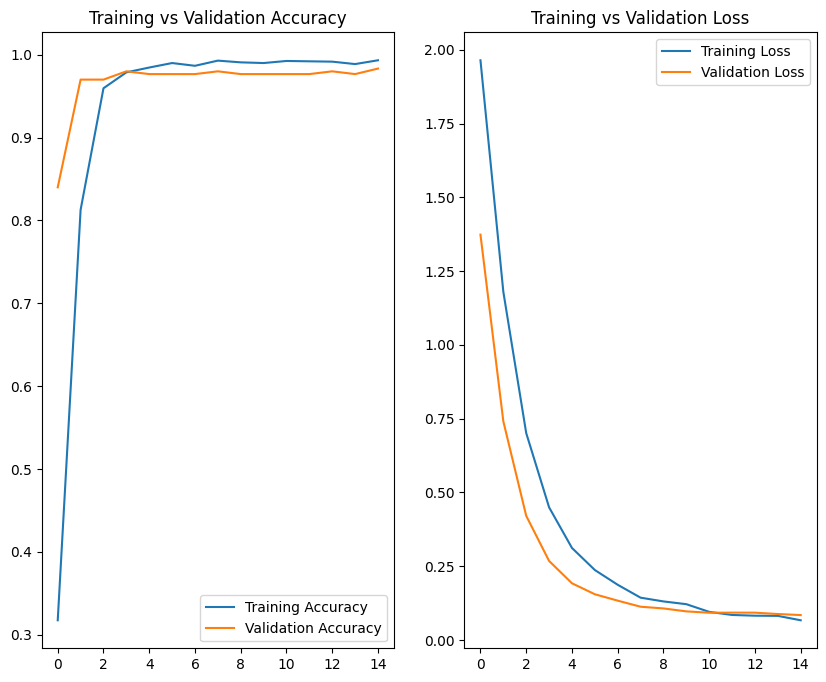

In [ ]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


In [ ]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - Accuracy: 0.9757 - loss: 0.0889
Test accuracy is0.9700, Test loss is 0.0979


In [ ]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step
[[29  0  0  0  0  1  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  0  1]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  1  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  1  1 28  0  0]
 [ 0  0  2  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       1.00      1.00      1.00        30
           2       0.91      0.97      0.94        30
           3       1.00      1.00      1.00        30
           4       1.00      1.00      1.00        30
           5       0.94      0.97      0.95        30
           6       0.93      0.93      0.93        30
           7       1.00      0.93      0.97        30
           8       1.00      0.93      0.97        30
           9       0.97      1.00      0.98        30

    accuracy                    

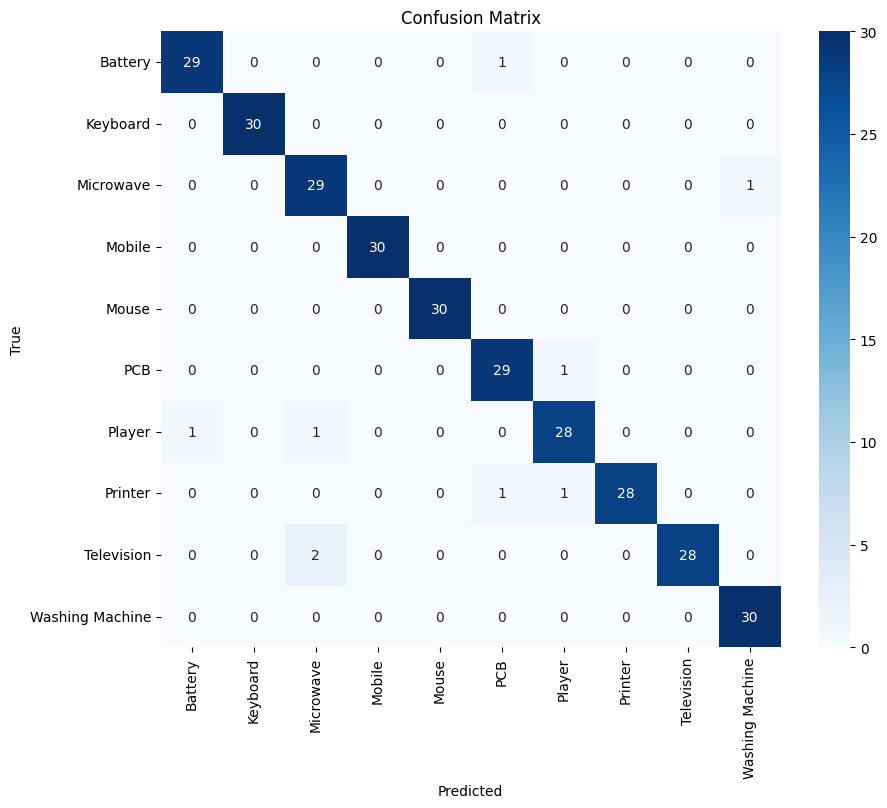

In [ ]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


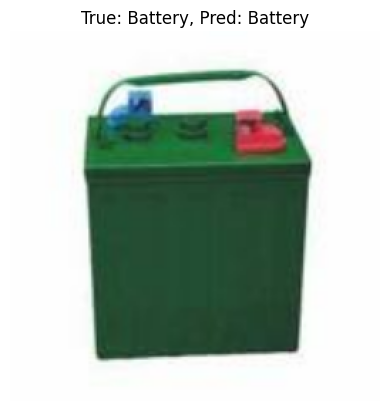

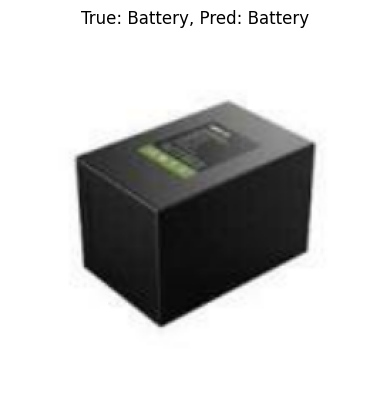

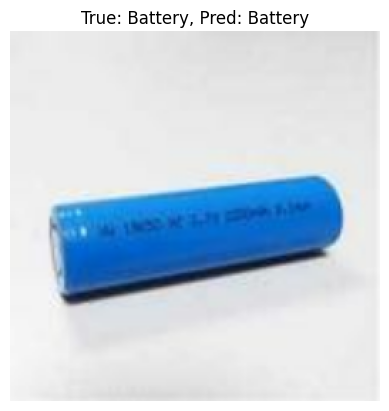

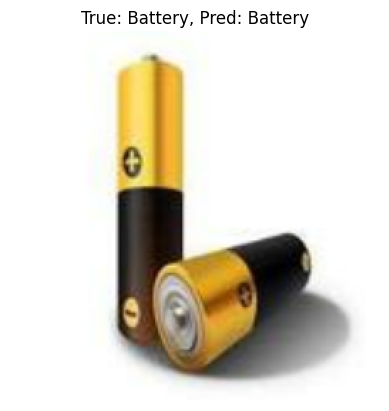

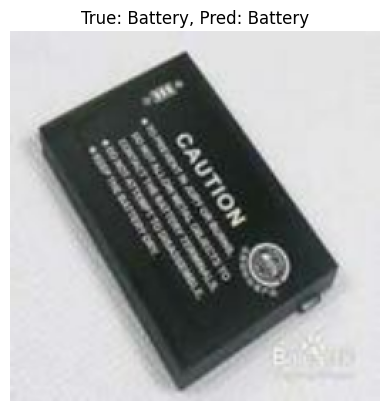

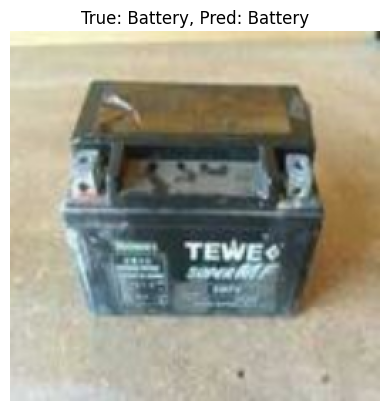

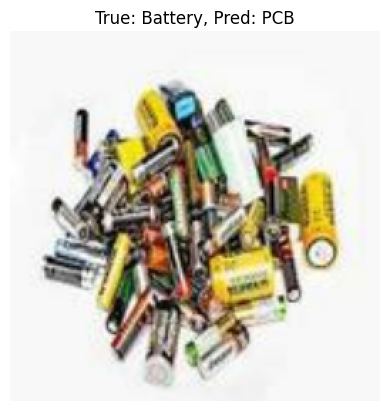

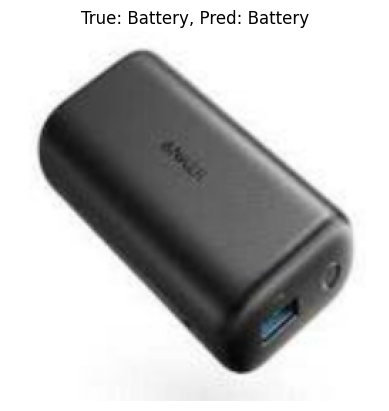

In [ ]:
### Display Sample Predictions: True Labels vs Predicted Labels
for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [ ]:
!cp Efficient_classify.keras /content/drive/MyDrive/Efficient_classify.keras

In [7]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('/content/drive/MyDrive/Efficient_classify.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 222 variables whereas the saved optimizer has 442 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [2]:
!pip install gradio

In [8]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((260, 260))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [9]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9d708a360820c9aa5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
